In [813]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
import plotly.io as pio 
from gurobipy import *

In [814]:
pd.options.plotting.backend = "plotly"
template = "plotly_white"
path_profile= "../data/SBAP_FCR_profile_test2.csv"
#path= r"C:\Users\tanjavov\Documents\MPC Optimization\data\myProfile.csv"
#profile.plot(template=template, labels={"value": "Current x100 [A]"})
path_output= r"C:\Users\tanjavov\Documents\Documents\KIMBAT PDS\kimbat-pds\ires-pds\output_ruleBased.csv"
#path_output= r"C:\Users\tanjavov\Documents\Documents\KIMBAT PDS\kimbat-pds\ires-pds\output_ConsqDist.csv"
#path_output= r"C:\Users\tanjavov\Documents\Documents\KIMBAT PDS\kimbat-pds\ires-pds\output_EqualDist.csv"
#path_output= r"C:\Users\tanjavov\Documents\Documents\KIMBAT PDS\kimbat-pds\ires-pds\output_MPC.csv"


profile = pd.read_csv(path_profile, index_col=0, parse_dates=True)
output= pd.read_csv(path_output)

#profile.plot(template=template, labels={"value": "Current x100 [A]"})

In [815]:

thermal_parameters = {

"loop_time":(profile.index[1] - profile.index[0]).seconds,
"dt": 30,
"v":0.1, #air speed from cooling fan: m/s   
#"h":1, #1-10 W/m2.K
"k_air": 0.026, #W/m.K
"rho_air":1.293, #kg/m3
"cp_air": 1005, #J/kg.K
#

"storage_params_1" : {
    "initial_temp": 300,  
    "amb_temp": 295,
    "length": 1.5, #m
    "num_cells": 65,
    "rho":3300, #(2.8-3.3)  g/cm^3 
    "cp": 1200, # (0.8-1.2) #J/g.K
    "k": 0.1, #  (0.1-0.5) W/m.K
    "cell_count":14,
    "R": 0.033, #Ohms
},


"storage_params_2" : {
    "initial_temp": 300,  
    "amb_temp": 295,
    "length": 1.5, #m
    "num_cells": 65,
    "rho":3300, #(2.8-3.3) g/cm^3 
    "cp": 1200, # (0.8-1.2) J/g.K
    "k": 0.1, #  (0.1-0.5) W/m.K
    "cell_count":14,
    "R": 0.033, #Ohms
}

}
thermal_parameters['dx1']       = thermal_parameters["storage_params_1"]['length']/(thermal_parameters["storage_params_1"]['num_cells']-1)
thermal_parameters['dx2']       = thermal_parameters["storage_params_2"]['length']/(thermal_parameters["storage_params_2"]['num_cells']-1)    
thermal_parameters['time_steps']   = int(thermal_parameters['loop_time']/thermal_parameters['dt'])
n = len(output)   
time = range(0, n)
time_steps= thermal_parameters['time_steps']


In [816]:
#stability analysis

dt= thermal_parameters['dt']    
dx1= thermal_parameters['dx1']
rho1= thermal_parameters["storage_params_1"]['rho']
cp1= thermal_parameters["storage_params_1"]['cp']
k1= thermal_parameters["storage_params_1"]['k']
alpha1= k1/(rho1*cp1)
r1 = (alpha1*dt/(dx1**2))

v= thermal_parameters["v"]
h= 12.12-1.16*v + 11.6*(v)**0.5
Bi = h*dx1/k1


print('alpha1: ',alpha1)
print('Fo: ',r1)   # Fo<0.5
print('dx1:',dx1)
print('BiotNo : ',Bi)
print('stability2:', r1*(Bi+1)) #Fo*(Bi+1) <= 0.5



alpha1:  2.5252525252525253e-08
Fo:  0.0013791245791245793
dx1: 0.0234375
BiotNo :  3.673181738858278
stability2: 0.006444899798775592


In [817]:
cp_air= thermal_parameters['cp_air']
rho_air= thermal_parameters['rho_air']
k_air= thermal_parameters['k_air']

alpha_air= k_air/(rho_air*cp_air)
#alpha_air = 0.000019
r_air= float(alpha_air*dt/(dx1**2))
print(alpha_air)

2.0008234157903444e-05


In [818]:
# Each cell is at a node of the FDM discrete grid. (alpha = k/rho*cp)
def diffusion_1D(thermal_parameters):
    dt= thermal_parameters['dt']
    time_steps= thermal_parameters['time_steps']
    
    dx1= thermal_parameters['dx1']
    dx2= thermal_parameters['dx2']

    rho1= thermal_parameters["storage_params_1"]['rho']
    rho2= thermal_parameters["storage_params_2"]['rho']
    rho_air= thermal_parameters['rho_air']

    cp1= thermal_parameters["storage_params_1"]['cp']
    cp2= thermal_parameters["storage_params_2"]['cp']
    cp_air= thermal_parameters['cp_air']

    R1= thermal_parameters["storage_params_1"]['R']
    R2= thermal_parameters["storage_params_2"]['R']

    k1= thermal_parameters["storage_params_1"]['k']
    k2= thermal_parameters["storage_params_2"]['k']
    k_air= thermal_parameters['k_air']

    T1_amb=thermal_parameters["storage_params_1"]['amb_temp']
    T2_amb=thermal_parameters["storage_params_2"]['amb_temp']

    cell_count1  = thermal_parameters["storage_params_1"]["cell_count"]
    cell_count2  = thermal_parameters["storage_params_2"]["cell_count"]

    v= thermal_parameters["v"]
    
    alpha1= k1/(rho1*cp1)
    alpha2= k2/(rho2*cp2)

    alpha_air= k_air/(rho_air*cp_air) #19e-6
    #alpha_air = 0.000019

    r1= alpha1*dt/(dx1**2)
    r2= alpha2*dt/(dx2**2)
    r_air= float(alpha_air*dt/(dx1**2))
    h= 12.12-1.16*v + 11.6*(v)**0.5

    
    
    T1 = [thermal_parameters["storage_params_1"]['initial_temp']]*thermal_parameters["storage_params_1"]['num_cells']
    #T1[0] = thermal_parameters["storage_params_1"]['amb_temp']
    #T1[thermal_parameters["storage_params_1"]['num_cells']-1] = thermal_parameters["storage_params_1"]['amb_temp']

    T1_string = np.zeros((n*time_steps, thermal_parameters["storage_params_1"]['num_cells']))
    T2_string = np.zeros((n*time_steps, thermal_parameters["storage_params_2"]['num_cells']))
    #print("temperatures_1: ", T1_string)      
    #print("temperatures_2: ", T2_string)

    T2 = [thermal_parameters["storage_params_2"]['initial_temp']]*thermal_parameters["storage_params_2"]['num_cells']
    #T2[0] = thermal_parameters["storage_params_2"]['amb_temp']
    #T2[thermal_parameters["storage_params_2"]['num_cells']-1] = thermal_parameters["storage_params_2"]['amb_temp']
    
    T1_string[0, :] = T1
    T1_string[:, 0] = T1_amb
    T1_string[:, thermal_parameters["storage_params_1"]['num_cells']-1] = T1_amb
    #for k in range(6,30,4):                      # adding another boundary condition =>> passive convection between the modules.
    #    T1_string[:, k] = T1_amb

    T2_string[0, :] = T2
    T2_string[:, 0] = T2_amb
    T2_string[:, thermal_parameters["storage_params_2"]['num_cells']-1] = T2_amb
    #print("temperatures_1: ", T1_string)      
    #print("temperatures_2: ", T2_string)

    for t in range(0,n*time_steps-1):
        #print("time step: ", t)
        #for m in range(1, time_steps):      
        for i in range(1, thermal_parameters["storage_params_1"]['num_cells']-1): 
            #if i%32==0: 
            #    T1_string[t+1,i] = r1*(T1_string[t,i+1]+ T1_string[t,i-1]) + (1-2*r1)*T1_string[t,i] + ((output.I1[(t//time_steps)])**2)*(cell_count1*R1)*dt/(rho1*cp1*0.3)                                #FTCS Scheme
            #elif i in range (31, 224, 32): 
            #    T1_string[t+1,i] = r1*(T1_string[t,i+1]+ T1_string[t,i-1]) + (1-2*r1)*T1_string[t,i] + ((output.I1[(t//time_steps)])**2)*(cell_count1*R1)*dt/(rho1*cp1*0.3)
            #elif i in range (33, 224, 32): 
            #    T1_string[t+1,i] = r1*(T1_string[t,i+1]+ T1_string[t,i-1]) + (1-2*r1)*T1_string[t,i] + ((output.I1[(t//time_steps)])**2)*(cell_count1*R1)*dt/(rho1*cp1*0.3) 
            #elif i==1:
            #    T1_string[t+1,i] = T1_string[t,i] + k1*dt* 2*(T1_string[t,i+1]-T1_string[t,i])/(rho1*cp1*dx1**2) + 2*h*dt*(T1_string[t,i-1]-T1_string[t,i])/(rho1*cp1*dx1)  
            #elif i == thermal_parameters["storage_params_1"]['num_cells']-2:
            #    T1_string[t+1,i] = T1_string[t,i] + k1*dt* 2*(T1_string[t,i-1]-T1_string[t,i])/(rho1*cp1*dx1**2) + 2*h*dt*(T1_string[t,i+1]-T1_string[t,i])/(rho1*cp1*dx1) 
            #elif i == 48 or i == 80 or i ==112 or i == 144 or i ==176 or i ==208:
            #    T1_string[t+1,i]  = r1*0.1*(T1_string[t,i+1]+ T1_string[t,i-1]) + (1-2*r1*0.1)*T1_string[t,i]   
            #else:
            #    T1_string[t+1,i]  = r1*(T1_string[t,i+1]+ T1_string[t,i-1]) + (1-2*r1)*T1_string[t,i]
            
            #if i%16==0: 
            #    T1_string[t+1,i] = r1*(T1_string[t,i+1]+ T1_string[t,i-1]) + (1-2*r1)*T1_string[t,i] + ((output.I1[(t//time_steps)])**2)*(cell_count1*R1)*dt/(rho1*cp1*0.3)                                #FTCS Scheme
            #elif i in range (15, 112, 16): 
            #    T1_string[t+1,i] = r1*(T1_string[t,i+1]+ T1_string[t,i-1]) + (1-2*r1)*T1_string[t,i] + ((output.I1[(t//time_steps)])**2)*(cell_count1*R1)*dt/(rho1*cp1*0.3)
            #elif i in range (17, 112, 16): 
            #    T1_string[t+1,i] = r1*(T1_string[t,i+1]+ T1_string[t,i-1]) + (1-2*r1)*T1_string[t,i] + ((output.I1[(t//time_steps)])**2)*(cell_count1*R1)*dt/(rho1*cp1*0.3) 
            #elif i==1:
            #    T1_string[t+1,i] = T1_string[t,i] + k1*dt* 2*(T1_string[t,i+1]-T1_string[t,i])/(rho1*cp1*dx1**2) + 2*h*dt*(T1_string[t,i-1]-T1_string[t,i])/(rho1*cp1*dx1)  
            #elif i == thermal_parameters["storage_params_1"]['num_cells']-2:
            #    T1_string[t+1,i] = T1_string[t,i] + k1*dt* 2*(T1_string[t,i-1]-T1_string[t,i])/(rho1*cp1*dx1**2) + 2*h*dt*(T1_string[t,i+1]-T1_string[t,i])/(rho1*cp1*dx1) 
            #elif i == 24 or i == 40 or i ==56 or i == 72 or i ==88 or i ==104:
            #    T1_string[t+1,i]  = r1*0.1*(T1_string[t,i+1]+ T1_string[t,i-1]) + (1-2*r1*0.1)*T1_string[t,i]   
            #else:
            #    T1_string[t+1,i]  = r1*(T1_string[t,i+1]+ T1_string[t,i-1]) + (1-2*r1)*T1_string[t,i]


            if i%8==0: 
                T1_string[t+1,i] = r1*(T1_string[t,i+1]+ T1_string[t,i-1]) + (1-2*r1)*T1_string[t,i] + ((output.I1[(t//time_steps)])**2)*(cell_count1*R1)*dt/(rho1*cp1*0.3)                                #FTCS Scheme
            elif i in range (7, 56, 8): 
                T1_string[t+1,i] = r1*(T1_string[t,i+1]+ T1_string[t,i-1]) + (1-2*r1)*T1_string[t,i] + ((output.I1[(t//time_steps)])**2)*(cell_count1*R1)*dt/(rho1*cp1*0.3)
            elif i in range (9, 56, 8): 
                T1_string[t+1,i] = r1*(T1_string[t,i+1]+ T1_string[t,i-1]) + (1-2*r1)*T1_string[t,i] + ((output.I1[(t//time_steps)])**2)*(cell_count1*R1)*dt/(rho1*cp1*0.3) 
            elif i==1:
                T1_string[t+1,i] = T1_string[t,i] + k1*dt* 2*(T1_string[t,i+1]-T1_string[t,i])/(rho1*cp1*dx1**2) + 2*h*dt*(T1_string[t,i-1]-T1_string[t,i])/(rho1*cp1*dx1)  
            elif i == thermal_parameters["storage_params_1"]['num_cells']-2:
                T1_string[t+1,i] = T1_string[t,i] + k1*dt* 2*(T1_string[t,i-1]-T1_string[t,i])/(rho1*cp1*dx1**2) + 2*h*dt*(T1_string[t,i+1]-T1_string[t,i])/(rho1*cp1*dx1) 
            elif i == 12 or i == 20 or i ==28 or i == 36 or i ==44 or i ==52:
                T1_string[t+1,i]  = r1*0.1*(T1_string[t,i+1]+ T1_string[t,i-1]) + (1-2*r1*0.1)*T1_string[t,i]   
            else:
                T1_string[t+1,i]  = r1*(T1_string[t,i+1]+ T1_string[t,i-1]) + (1-2*r1)*T1_string[t,i]

            #if i%4==0: 
            #    T1_string[t+1,i] = r1*(T1_string[t,i+1]+ T1_string[t,i-1]) + (1-2*r1)*T1_string[t,i] + ((output.I1[(t//time_steps)])**2)*(cell_count1*R1)*dt/(rho1*cp1*0.3)                                #FTCS Scheme
            #elif i in range (3, 28, 4): 
            #    T1_string[t+1,i] = r1*(T1_string[t,i+1]+ T1_string[t,i-1]) + (1-2*r1)*T1_string[t,i] + ((output.I1[(t//time_steps)])**2)*(cell_count1*R1)*dt/(rho1*cp1*0.3)
            #elif i in range (5, 28, 4): 
            #    T1_string[t+1,i] = r1*(T1_string[t,i+1]+ T1_string[t,i-1]) + (1-2*r1)*T1_string[t,i] + ((output.I1[(t//time_steps)])**2)*(cell_count1*R1)*dt/(rho1*cp1*0.3) 
            #elif i==1:
            #    T1_string[t+1,i] = T1_string[t,i] + k1*dt* 2*(T1_string[t,i+1]-T1_string[t,i])/(rho1*cp1*dx1**2) + 2*h*dt*(T1_string[t,i-1]-T1_string[t,i])/(rho1*cp1*dx1)  
            #elif i == thermal_parameters["storage_params_1"]['num_cells']-2: 
            #    T1_string[t+1,i] = T1_string[t,i] + k1*dt* 2*(T1_string[t,i-1]-T1_string[t,i])/(rho1*cp1*dx1**2) + 2*h*dt*(T1_string[t,i+1]-T1_string[t,i])/(rho1*cp1*dx1) 
            #elif i == 6 or i == 10 or i ==14 or i == 18 or i ==22 or i ==26:
            #    T1_string[t+1,i]  = r1*0.1*(T1_string[t,i+1]+ T1_string[t,i-1]) + (1-2*r1*0.1)*T1_string[t,i]   
            #else:
            #    T1_string[t+1,i]  = r1*(T1_string[t,i+1]+ T1_string[t,i-1]) + (1-2*r1)*T1_string[t,i]    
        
        
        for i in range(1, thermal_parameters["storage_params_2"]['num_cells'] - 1):
            if i%8==0: 
                T2_string[t+1,i] = r2*(T2_string[t,i+1]+ T2_string[t,i-1]) + (1-2*r2)*T2_string[t,i] + ((output.I2[(t//time_steps)])**2)*(cell_count2*R2)*dt/(rho2*cp2*0.3)                                #FTCS Scheme
            elif i in range (7, 56, 8): 
                T2_string[t+1,i] = r2*(T2_string[t,i+1]+ T2_string[t,i-1]) + (1-2*r2)*T2_string[t,i] + ((output.I2[(t//time_steps)])**2)*(cell_count2*R2)*dt/(rho2*cp2*0.3)
            elif i in range (9, 56, 8): 
                T2_string[t+1,i] = r2*(T2_string[t,i+1]+ T2_string[t,i-1]) + (1-2*r2)*T2_string[t,i] + ((output.I2[(t//time_steps)])**2)*(cell_count2*R1)*dt/(rho2*cp2*0.3) 
            elif i==1:
                T2_string[t+1,i] = T2_string[t,i] + k2*dt* 2*(T2_string[t,i+1]-T2_string[t,i])/(rho2*cp2*dx2**2) + 2*h*dt*(T2_string[t,i-1]-T2_string[t,i])/(rho2*cp2*dx2)  
            elif i == thermal_parameters["storage_params_1"]['num_cells']-2:
                T2_string[t+1,i] = T2_string[t,i] + k2*dt* 2*(T2_string[t,i-1]-T2_string[t,i])/(rho2*cp2*dx2**2) + 2*h*dt*(T2_string[t,i+1]-T2_string[t,i])/(rho2*cp2*dx2) 
            elif i == 12 or i == 20 or i ==28 or i == 36 or i ==44 or i ==52:
                T2_string[t+1,i]  = r2*0.1*(T2_string[t,i+1]+ T2_string[t,i-1]) + (1-2*r2*0.1)*T2_string[t,i]   
            else:
                T2_string[t+1,i]  = r2*(T2_string[t,i+1]+ T2_string[t,i-1]) + (1-2*r2)*T2_string[t,i]  
                    
        #T1_string[t+1, :] = T1
        #T2_string[t+1, :] = T2  
        #print("temperatures_1: ", T1_string)      
        #print("temperatures_2: ", T2_string)     
                  
    return T1_string, T2_string

# Solve the heat diffusion equation
T1_string, T2_string = diffusion_1D(thermal_parameters)

#print("temperatures_1: ", T1_string)      
#print("temperatures_2: ", T2_string)

In [819]:
scale= (thermal_parameters["storage_params_1"]['length']/thermal_parameters["storage_params_1"]['num_cells'])*100

In [820]:
#print(output.I1)
#print(output.I2)

In [821]:
#x = np.arange(0, thermal_parameters["storage_params_1"]['num_cells'])
#length= x*scale
#y = np.arange(0, n*time_steps)
#y_days = y*30/(3600*24)#
##fig = go.Figure(data=[go.Surface(x=np.arange(0,thermal_parameters["storage_params_1"]['num_cells']), y=list(range(0,n*time_steps)), z=T1_string)])
#fig = go.Figure(data=[go.Surface(x=length, y=y_days, z=T1_string)])
##  Set the axis labels
#fig.update_layout(scene=dict(
#    xaxis=dict(title='String Length (cm)', titlefont=dict(size=30)),
#    yaxis=dict(title='Time (days)', titlefont=dict(size=30)),
#    zaxis=dict(title='Temperature (K)', titlefont=dict(size=30))#,tickvals=[282, 285,290,295,300,305])
#))
##fig.update_layout(scene_zaxis_range=[280, 330], height=900, width=2000, title="Temperature Spatial Evolution of Battery String 1")
##fig.update_traces(cmin=280, cmax=330)#
##pio.write_image(fig, "temperature_spatial_evolution.svg", format='svg', width=2000, height=900)#
## Save the figure as a high-resolution PNG file
##pio.write_image(fig, "temperature_spatial_evolution.png", format='png', width=2000, height=900, scale=2)
##plt.savefig("temperature_spatial_evolution.svg", dpi=300, bbox_inches="tight")
##plt.savefig("temperature_spatial_evolution.png", dpi=300, bbox_inches="tight")
## Show the plot
#fig.show()



In [822]:
#x = np.arange(0, thermal_parameters["storage_params_2"]['num_cells'])
#length= x*scale
#y = np.arange(0, n*time_steps)
#y_days = y*30/(3600*24)
#
##fig = go.Figure(data=[go.Surface(x=np.arange(0,thermal_parameters["storage_params_2"]['num_cells']), y=list(range(0,n*time_steps)), z=T2_string)])
#fig = go.Figure(data=[go.Surface(x=length, y=y_days, z=T2_string)])
##  Set the axis labels
#fig.update_layout(scene=dict(
#    xaxis=dict(title='String Length (cm)', titlefont=dict(size=18)),
#    yaxis=dict(title='Time (days)', titlefont=dict(size=18)),
#    zaxis=dict(title='Temperature (K)', titlefont=dict(size=18),tickvals=[282, 285,290,295,300,305,310,315,320,325])
#))
#fig.update_layout(scene_zaxis_range=[280, 320], height=900, width=900, title="Temperature Spatial Evolution of Battery String 2")
#fig.update_traces(cmin=290, cmax=320)
#
#
## Show the plot
#fig.show()



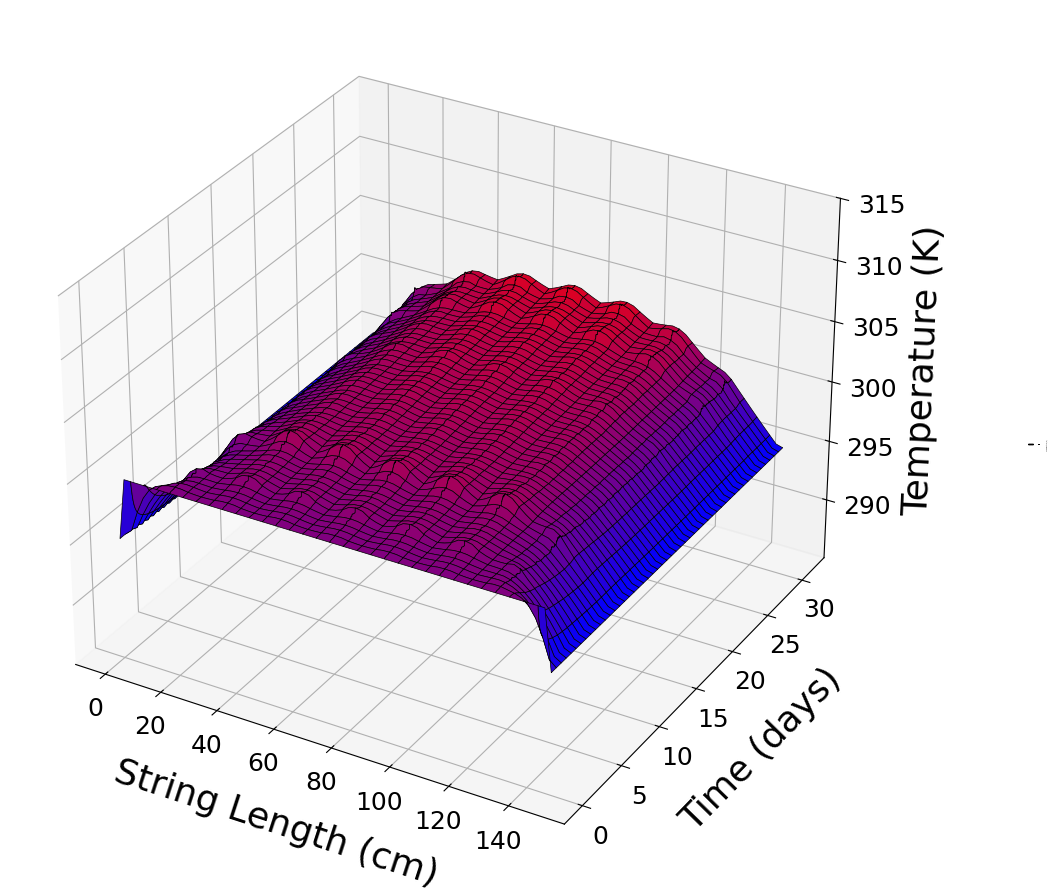

In [823]:
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.pyplot as plt

# Prepare x and y axis data
x = np.arange(0, thermal_parameters["storage_params_1"]['num_cells']) * scale
y = np.arange(0, n * time_steps) * dt / (3600 * 24)
X, Y = np.meshgrid(x, y)

# Create the figure and a 3D Axes
fig = plt.figure(figsize=(30, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['blue', 'red', 'yellow'])

# Plot the surface with the custom colormap object
surf = ax.plot_surface(X, Y, T1_string, cmap=custom_cmap, vmin=295, vmax=315, edgecolor='k', linewidth=0.5)

# Set the axis labels
ax.set_xlabel('String Length (cm)', fontsize=26,labelpad=20)
ax.set_ylabel('Time (days)', fontsize=26,labelpad=20)
ax.set_zlabel('Temperature (K)', fontsize=26,labelpad=20)

# Customize the tick parameters
ax.tick_params(axis='both', which='major', labelsize=18)  # Adjust 'labelsize' to your preferred font size
ax.tick_params(axis='z', which='major', labelsize=18,pad=10)

# Set the z-axis limits and ticks
ax.set_zlim(285, 315)
ax.zaxis.set_ticks([290, 295, 300, 305, 310, 315])

## Add a color bar which maps values to colors
colorbar = fig.colorbar(surf, shrink=0, aspect=0.1)
colorbar.set_ticks([285, 290, 295, 300, 305, 310, 315, 320])
colorbar.set_label('Temperature (K)', fontsize=0)  # Label for the color bar
colorbar.ax.tick_params(labelsize=0)

plt.tight_layout()
#plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.1)

# Save the figure as a high-resolution SVG file
#plt.savefig("temperature_spatial_evolution.svg", format='svg', dpi=300, bbox_inches="tight")

# Save the figure as a high-resolution PNG file
plt.savefig("temperature_spatial_evolution.png", format='png', dpi=100, bbox_inches="tight")

# Show the plot
plt.show()


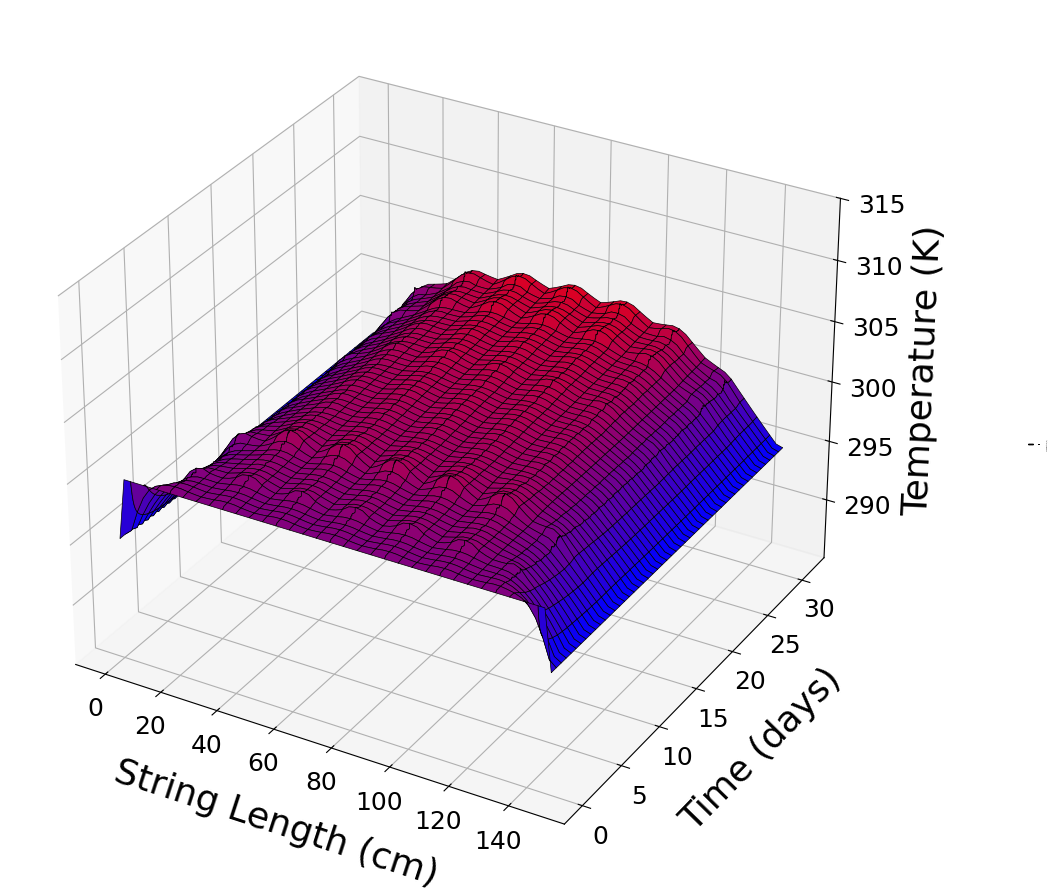

In [824]:
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.pyplot as plt

# Prepare x and y axis data
x = np.arange(0, thermal_parameters["storage_params_2"]['num_cells']) * scale
y = np.arange(0, n * time_steps) * dt / (3600 * 24)
X, Y = np.meshgrid(x, y)

# Create the figure and a 3D Axes
fig = plt.figure(figsize=(30, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['blue', 'red', 'yellow'])

# Plot the surface with the custom colormap object
surf = ax.plot_surface(X, Y, T2_string, cmap=custom_cmap, vmin=295, vmax=315, edgecolor='k', linewidth=0.5)

# Set the axis labels
ax.set_xlabel('String Length (cm)', fontsize=26,labelpad=20)
ax.set_ylabel('Time (days)', fontsize=26,labelpad=20)
ax.set_zlabel('Temperature (K)', fontsize=26,labelpad=20)

# Customize the tick parameters
ax.tick_params(axis='both', which='major', labelsize=18)  # Adjust 'labelsize' to your preferred font size
ax.tick_params(axis='z', which='major', labelsize=18,pad=10)

# Set the z-axis limits and ticks
ax.set_zlim(285, 315)
ax.zaxis.set_ticks([290, 295, 300, 305, 310, 315])

## Add a color bar which maps values to colors
colorbar = fig.colorbar(surf, shrink=0, aspect=0.1)
colorbar.set_ticks([285, 290, 295, 300, 305, 310, 315, 320])
colorbar.set_label('Temperature (K)', fontsize=0)  # Label for the color bar
colorbar.ax.tick_params(labelsize=0)

plt.tight_layout()
#plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.1)

# Save the figure as a high-resolution SVG file
#plt.savefig("temperature_spatial_evolution.svg", format='svg', dpi=300, bbox_inches="tight")

# Save the figure as a high-resolution PNG file
plt.savefig("temperature_spatial_evolution2.png", format='png', dpi=100, bbox_inches="tight")

# Show the plot
plt.show()


In [825]:
fig = go.Figure()
fig.update_layout(template=template)
fig.add_trace(go.Scatter(x=np.arange(0,thermal_parameters["storage_params_2"]['num_cells']), y=T1_string[-1], name="Temp 1_final", line=dict(color="orange")))
fig.add_trace(go.Scatter(x=np.arange(0,thermal_parameters["storage_params_2"]['num_cells']), y=T1_string[0], name="Temp 1_initial", line=dict(color="orange", dash="dot")))
fig.add_trace(go.Scatter(x=np.arange(0,thermal_parameters["storage_params_1"]['num_cells']), y=T2_string[-1], name="Temp 2_final", line=dict(color="green")))
fig.add_trace(go.Scatter(x=np.arange(0,thermal_parameters["storage_params_1"]['num_cells']), y=T2_string[0], name="Temp 2_initial", line=dict(color="green", dash='dot')))

fig.update_xaxes(title="Position")
fig.update_yaxes(title="Temperature (k)")
#fig.update_traces(line_shape="hv")
fig.update_layout(
    width=900,  # Specify the width in pixels
    height=500  # Specify the height in pixels
)

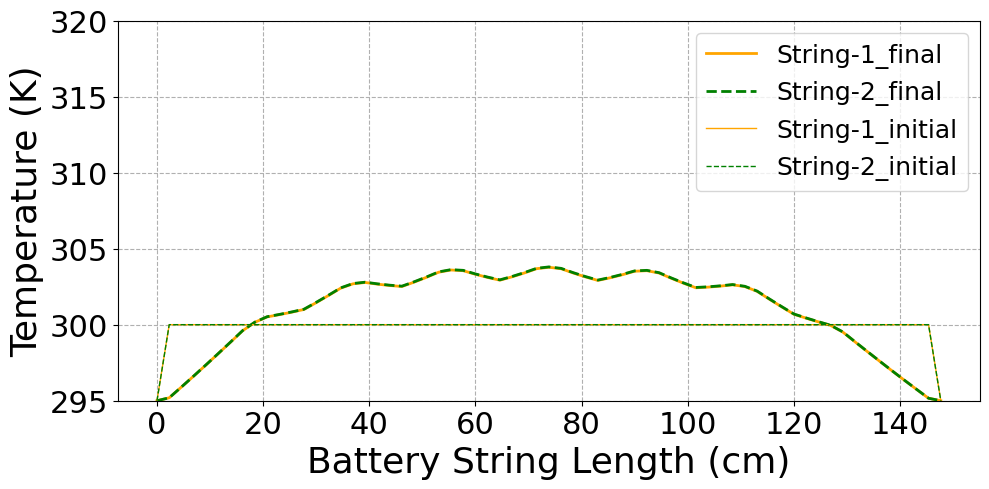

In [826]:

# Create a new figure
fig, ax = plt.subplots(figsize=(10, 5))
scale= (thermal_parameters["storage_params_1"]['length']/thermal_parameters["storage_params_1"]['num_cells'])*100
# Plot the data
ax.plot(scale*np.arange(0,thermal_parameters["storage_params_1"]['num_cells']),T1_string[-1], label="String-1_final", color="orange", linewidth=2)
ax.plot(scale*np.arange(0,thermal_parameters["storage_params_2"]['num_cells']),T2_string[-1], label="String-2_final", color="green", linewidth=2,linestyle='--')
ax.plot(scale*np.arange(0,thermal_parameters["storage_params_1"]['num_cells']),T1_string[0], label="String-1_initial", color="orange", linewidth=1)
ax.plot(scale*np.arange(0,thermal_parameters["storage_params_2"]['num_cells']),T2_string[0], label="String-2_initial", color="green", linewidth=1, linestyle='--')

# Set labels and title
ax.set_xlabel("Battery String Length (cm)", fontsize=26)
ax.set_ylabel("Temperature (K)", fontsize=26)
#ax.set_title("State of Charge Over Time")
#ax.set_ylim( ymin=288, ymax=320)
# Add grid lines
ax.grid(True, linestyle='--')

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
ax.set_ylim(295, 315)
ax.yaxis.set_ticks([295, 300, 305, 310, 315, 320])

# Add a legend
ax.legend(fontsize=18)

# Adjust layout
plt.tight_layout()

# Save the plot as a high-quality image (e.g., PNG or PDF)
#plt.savefig("MPC_Temp_endtime.png", dpi=300, bbox_inches="tight")
#plt.savefig("Conseq_Temp_endtime.png", dpi=300, bbox_inches="tight")
plt.savefig("RuleBased_Temp_endtime.png", dpi=300, bbox_inches="tight")
# Or, if you prefer to display the plot interactively, use plt.show()
# plt.show()


In [827]:
[list((range(1,10)))]

[[1, 2, 3, 4, 5, 6, 7, 8, 9]]

In [828]:
print(T1_string[:,16])
print(65*1.6)

[300.         300.00000364 300.00000727 ... 302.68629367 302.68602265
 302.68575162]
104.0


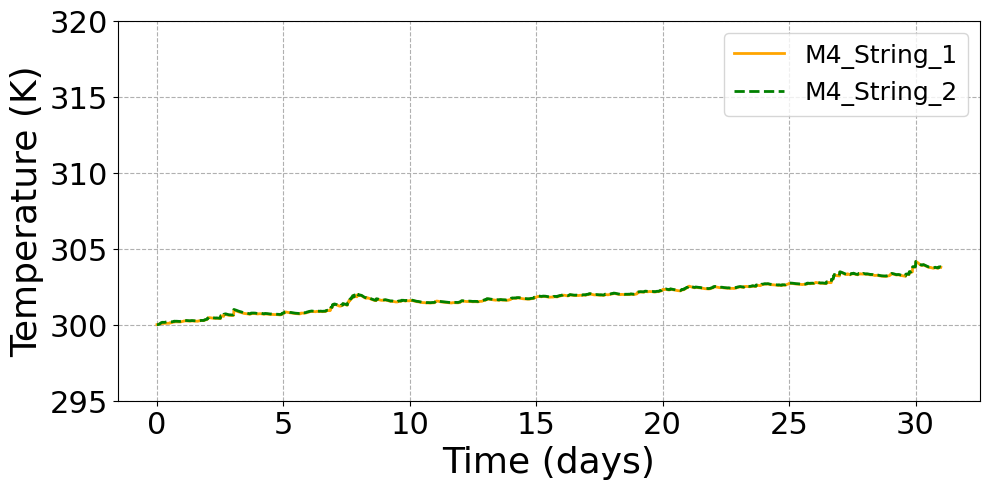

In [829]:
# Create a new figure
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the data
ax.plot((np.arange(0, n*time_steps))*30/(3600*24),T1_string[:,32], label="M4_String_1", color="orange", linewidth=2)
ax.plot((np.arange(0, n*time_steps))*30/(3600*24),T2_string[:,32], label="M4_String_2", color="green", linewidth=2, linestyle='--')
#ax.plot(3*np.arange(0,thermal_parameters["storage_params_1"]['num_cells']),T1_string[:,16], label="Temp 1_initial", color="orange", linewidth=2,linestyle='--')
#ax.plot(3*np.arange(0,thermal_parameters["storage_params_2"]['num_cells']),T2_string[:,16], label="Temp 2_initial", color="green", linewidth=2, linestyle='--')

# Set labels and title
ax.set_xlabel("Time (days)", fontsize=26)
ax.set_ylabel("Temperature (K)", fontsize=26)

#ax.set_title("State of Charge Over Time")

# Add grid lines
ax.grid(True, linestyle='--')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

ax.set_ylim(295, 315)
ax.yaxis.set_ticks([295, 300, 305, 310, 315, 320])

ax.legend(fontsize=18)

#ax.set_ylim( ymin=288, ymax=320)
# Adjust layout
plt.tight_layout()

# Save the plot as a high-quality image (e.g., PNG or PDF)
#plt.savefig("Conseq_Temp_M4.png", dpi=300, bbox_inches="tight")
#plt.savefig("Equal_Temp_M4.png", dpi=300, bbox_inches="tight")
#plt.savefig("MPC_Temp_M4.png", dpi=300, bbox_inches="tight")
plt.savefig("RuleBased_Temp_M4.png", dpi=300, bbox_inches="tight")
# Or, if you prefer to display the plot interactively, use plt.show()
# plt.show()

In [830]:
# Create a DataFrame with a single column (replace this with your data)
data = {'Time (days)': (np.arange(0, n*time_steps)*30/(3600*24)),
    'Temperature': T1_string[:, 32]
}

df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
#df.to_csv('M4_temp_data_rulebased.csv', index=False)
#df.to_csv('M4_temp_data_consq.csv', index=False)
#df.to_csv('M4_temp_data_equal.csv', index=False)
#df.to_csv('M4_temp_data_MPC.csv', index=False)

KeyError: 'Temperature_M4_Conseq'

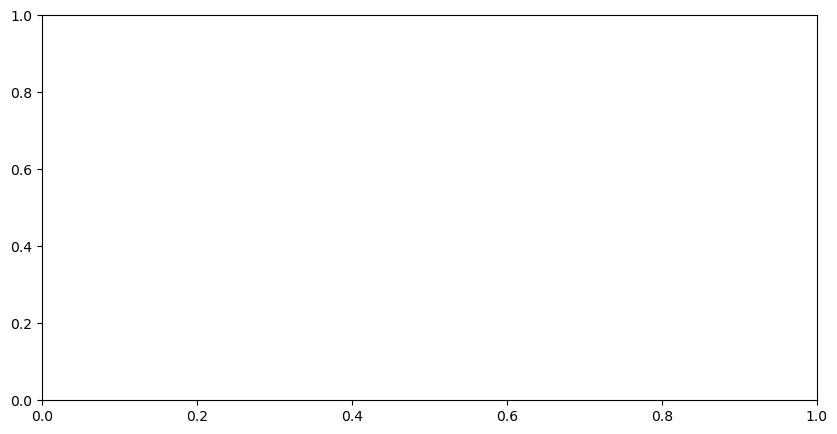

In [832]:

path_M4= r"C:\Users\tanjavov\Documents\Documents\KIMBAT PDS\kimbat-pds\ires-pds\M4_temp_data_allstrategies.csv"

data2 = pd.read_csv(path_M4)#, index_col=0, parse_dates=True)

fig, ax = plt.subplots(figsize=(10, 5))

x = data2['time']
y1= data2['temperature_M4_Conseq']
y2 = data2['temperature_M4_MPC']
y3 = data2['temperature_M4_Equal']
y4 = data2['temperature_M4_RuleBased']


ax.plot(x, y1, label="Temperature_M4_Consec", color="red", linewidth=2)
ax.plot(x, y3, label='Temperature_M4_Equal', color="orange", linewidth=2)
ax.plot(x, y4, label='Temperature_M4_RuleBased', color="blue", linewidth=2, linestyle="--")
ax.plot(x, y2, label='Temperature_M4_MPC', color="green", linewidth=2)

ax.set_xlabel("Time (days)", fontsize=26)
ax.set_ylabel("Temperature (K)", fontsize=26)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

yticks_positions = [295, 300, 305, 310, 315, 320]  # Example y-ticks
ax.set_yticks(yticks_positions)
ax.set_yticklabels([f'{val}' for val in yticks_positions], fontsize=22)

# Add grid lines
ax.grid(True, linestyle='--')

# Add a legend
ax.legend(fontsize=18)
plt.tight_layout()


plt.savefig("M4_comparison.png", dpi=300, bbox_inches='tight') 